# PH SMK Test

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running a snakemake workflow.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from IPython.display import display
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

import ops
from ops.firesnake import Snake
from ops.imports_ipython import *
from ops.qc import *

## Helper Functions

In [2]:
# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile):
    image_paths = []
    
    # For PH, we typically have a single multichannel image per well/tile
    image_name = preprocess_pattern.format(well=well, tile=tile)
    image_path = f"{input_files_dir}/{image_name}"
    image_paths.append(image_path)
    
    return image_paths

# custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)

    return cmap

## SET PARAMETERS

### Loading, aligning, detecting candiate reads

- `INPUT_FILES_DIR`: Directory for loading SBS image data and IC data
- `OUPUT_FILES_DIR`: Directory for saving outputs of this notebook 
- `PREPROCESS_PATTERN`: Pattern of file names resulting from preprocessing
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `PREPROCESS_PATTERN`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

In [3]:
# Directory for loading and saving files
INPUT_FILES_DIR = "input"
OUTPUT_FILES_DIR = "output/test"

# Define the file pattern
PREPROCESS_PATTERN = '20X_{well}_Tile-{tile}.phenotype.tif'

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = "A1"
TILES = 1
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Microplot information
DISPLAY_RANGES = [
    [500, 20000],
    [800, 5000],
    [800, 5000],
    [800, 5000]
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

In [5]:
print("Loading input images...")
input_image_paths = generate_file_paths(
    f"{INPUT_FILES_DIR}/ph_tifs", PREPROCESS_PATTERN, WELLS, TILES
)
input_image = read(input_image_paths[0])
print(f"Input image shape: {input_image.shape}")
# parse description from input image
description = parse(input_image_paths[0])
keys_to_remove = ["cycle", "tag", "file"]
for key in keys_to_remove:
    description.pop(key, None)
print(f"Input file description: {description}")

Loading input images...
Input image shape: (4, 2400, 2400)
Input file description: {'subdir': 'input/ph_tifs', 'mag': '20X', 'well': 'A1', 'tile': '1', 'ext': 'tif'}


## SET PARAMETERS

### Illumination correction and segmentation

- `IC_PREPROCESS_PATTERN`: Pattern of file names resulting from illumination correction preprocessing.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.

In [10]:
# Define the ic file pattern
IC_PREPROCESS_PATTERN = f'20X_{WELLS}.phenotype.illumination_correction.tif'

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 1

Applying illumination correction to segmentation cycle image...
Example corrected image:


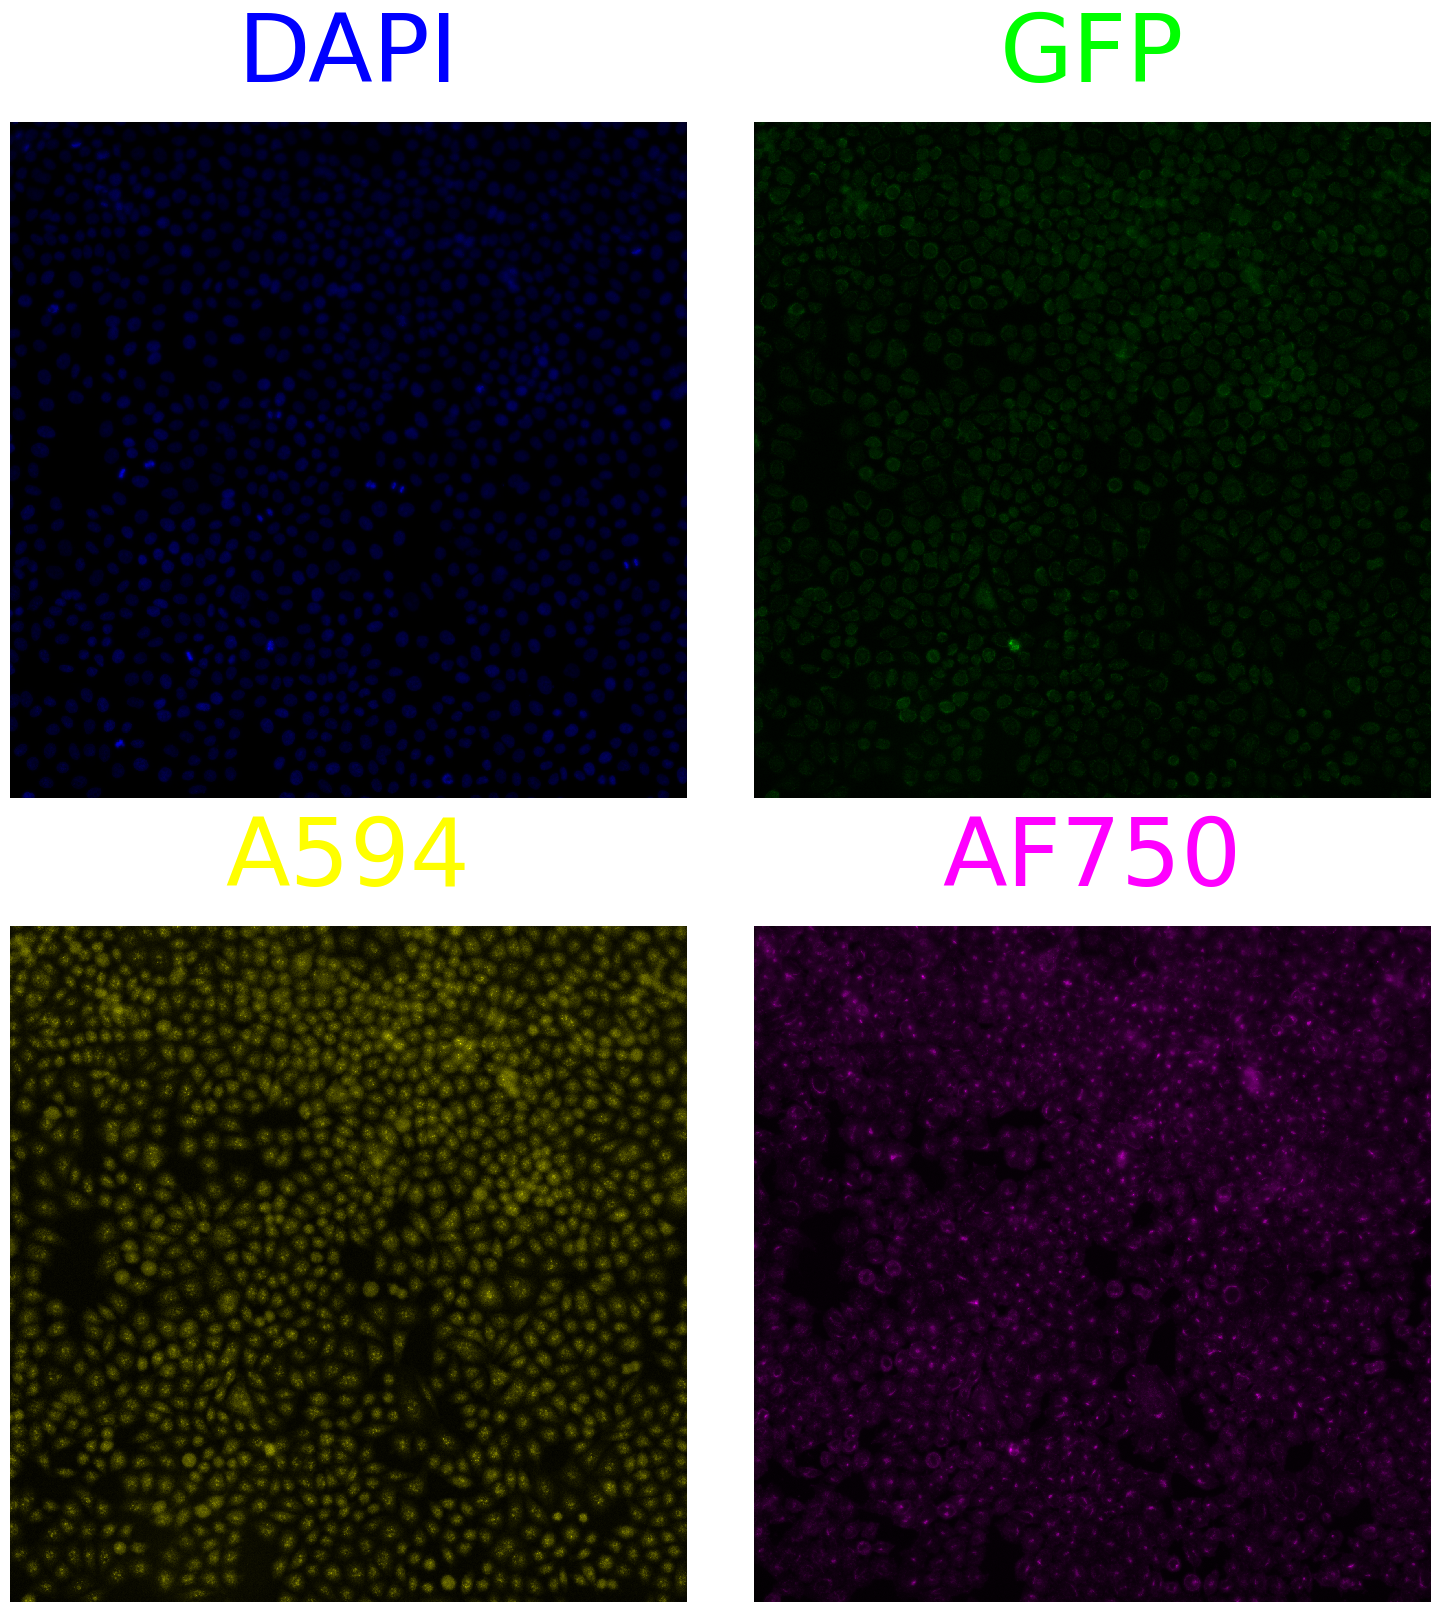

Preparing IC segmentation image for CellPose...


/opt/homebrew/anaconda3/envs/ops_dev/lib/python3.11/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [13]:
print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
icf_file_path = f"{INPUT_FILES_DIR}/ph_ic_tifs/{IC_PREPROCESS_PATTERN}".format(
    well=WELLS,
)
correction_image = read(icf_file_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = Snake._apply_illumination_correction(input_image, correction=correction_image)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(corrected_image[0,:,:],
                                             cmaps = 'pure_blue',
                                             channel_names='DAPI')
ph1_microshow = microplot.Microimage(corrected_image[1,:,:],
                                             cmaps = 'pure_green',
                                             channel_names='GFP')
ph2_microshow = microplot.Microimage(corrected_image[2,:,:],
                                             cmaps = 'pure_yellow',
                                             channel_names='A594')
ph3_microshow = microplot.Microimage(corrected_image[3,:,:],
                                             cmaps = 'pure_magenta',
                                             channel_names='AF750')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], ph0_microshow)
panel.add_element([0,1], ph1_microshow)
panel.add_element([1,0], ph2_microshow)
panel.add_element([1,1], ph3_microshow)
panel.add_channel_label()
plt.show()

print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = Snake._prepare_cellpose(corrected_image, DAPI_INDEX, CYTO_CHANNEL)
save(name(description, tag='prepared_cellpose', subdir=OUTPUT_FILES_DIR), cellpose_rgb)
# note, this process is done during the _segment_cellpose method below as well
# use the prepared_cellpose image to test CellPose (see below)